In [1]:
import os
os.chdir('./DDE')

import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch import nn 
import copy

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.model_selection import KFold

from dde_config import dde_NN_config
from dde_torch import dde_NN, simple_autoencoder_NN, simple_NN, dde_NN_Large_Predictor
from stream_dde import supData, unsupData

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [5]:
def test_dde_nn(data_generator, model_nn):
    y_pred = []
    y_label = []
    #model_nn.eval()
    for i, (v_D, label) in enumerate(data_generator):
        recon, code, score, Z_f, z_D = model_nn(v_D.float().cuda())
        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score)).detach().cpu().numpy()
        label_ids = label.to('cpu').numpy()
        y_label = y_label + label_ids.flatten().tolist()
        y_pred = y_pred + logits.flatten().tolist()

    return roc_auc_score(y_label, y_pred), y_pred


def main_dde_nn(seed):
    torch.manual_seed(seed)    # reproducible torch:2 np:3
    np.random.seed(seed)
    config = dde_NN_config()
    pretrain_epoch = config['pretrain_epoch']
    pretrain_epoch = 0
    train_epoch = 8
    lr = config['LR']
    thr = config['recon_threshold']
    recon_loss_coeff = config['reconstruction_coefficient']
    proj_coeff = config['projection_coefficient']
    lambda1 = config['lambda1']
    lambda2 = config['lambda2']
    BATCH_SIZE = config['batch_size']
    
    loss_r_history = []
    loss_p_history = []
    loss_c_history = []
    loss_history = []
    
    #model_nn = dde_NN_Large_Predictor(**config)
    #path = 'model_train_checkpoint_deepDDI_small_EarlyStopping_SemiSup_Full.pt'
    path = 'model_pretrain_checkpoint_1.pt'
    model_nn = torch.load(path)
    
    model_nn.cuda()
    
    #if torch.cuda.device_count() > 1:
    #    print("Let's use", torch.cuda.device_count(), "GPUs!")
    #    model_nn = nn.DataParallel(model_nn)
        
    opt = torch.optim.Adam(model_nn.parameters(), lr = lr)
    
    print('--- Data Preparation ---')
    
    params = {'batch_size': BATCH_SIZE,
              'shuffle': True,
              'num_workers': 6}

    dataFolder = '../../../../../scratch/kh2383/DFI_data'

    #df_unsup = pd.read_csv(dataFolder + '/data/unsup_dataset.csv', names = ['idx', 'input1_SMILES', 'input2_SMILES', 'type']).drop(0)# pairs dataframe input1_smiles, input2_smiles
    df_ddi = pd.read_csv(dataFolder + '/data/deepDDI_small/fold2/df_ddi_train_val.csv')  # ddi dataframe drug1_smiles, drug2_smiles

    #5-fold
    kf = KFold(n_splits = 8, shuffle = True, random_state = 1)
    #get the 1st fold index
    fold_index = next(kf.split(df_ddi), None)
    
    #ids_unsup = df_unsup.index.values
    partition_sup = {'train': fold_index[0], 'val': fold_index[1]}
    labels_sup = df_ddi.label.values

    #num_of_iter_per_epoch = len(partition_sup['train']) / BATCH_SIZE

    #unsup_set = unsupData(ids_unsup, df_unsup)
    #unsup_generator = data.DataLoader(unsup_set, **params)

    training_set = supData(partition_sup['train'], labels_sup, df_ddi)
    training_generator_sup = data.DataLoader(training_set, **params)

    validation_set = supData(partition_sup['val'], labels_sup, df_ddi)
    validation_generator_sup = data.DataLoader(validation_set, **params)
    
    max_auc = 0
    model_max = copy.deepcopy(model_nn)
    
    print('--- Pre-training Starts ---')
    torch.backends.cudnn.benchmark = True
    #len_unsup = len(unsup_generator)
    for pre_epo in range(pretrain_epoch):
        for i, v_D in enumerate(unsup_generator):
            v_D = v_D.float().cuda()
            recon, code, score, Z_f, z_D = model_nn(v_D)
            loss_r = recon_loss_coeff * F.binary_cross_entropy(recon, v_D.float())
            #print(sum(sum(v_D.float())))
            #print(torch.norm(z_D - torch.matmul(code, Z_f)))
            #loss_p = proj_coeff * (torch.norm(z_D - torch.matmul(code, Z_f)) + lambda1 * torch.sum(torch.abs(code)) / BATCH_SIZE
            #                       + lambda2 * torch.norm(Z_f, p='fro')) / BATCH_SIZE
            loss_p = proj_coeff * (torch.norm(z_D - torch.matmul(code, Z_f)) + lambda1 * torch.sum(torch.abs(code)) / BATCH_SIZE + lambda2 * torch.norm(Z_f, p='fro') / BATCH_SIZE)
            loss = loss_r + loss_p
            
            loss_r_history.append(loss_r)
            loss_p_history.append(loss_p)
            loss_history.append(loss)

            opt.zero_grad()
            loss.backward()
            opt.step()
            
            if(i % 10 == 0):
                print('Pre-Training at Epoch ' + str(pre_epo) + ' iteration ' + str(i) + ', total loss is '
                      + '%.3f' % (loss.cpu().detach().numpy()) + ', proj loss is ' + '%.3f' % (loss_p.cpu().detach().numpy()) 
                      + ', recon loss is ' + '%.3f' % (loss_r.cpu().detach().numpy()))

            if loss_r < thr:
                # smaller than certain reconstruction error, -> go to training step
                break
        
            if i == int(len_unsup/4):
                torch.save(model_nn, 'model_pretrain_checkpoint_1.pt')
            if i == int(len_unsup/2):
                torch.save(model_nn, 'model_pretrain_checkpoint_1.pt')
        torch.save(model_nn, 'model_nn_pretrain.pt')
        
    #model_nn = torch.load('model_train_checkpoint_1000_iter_0_epoch.pt')
    
    print('--- Go for Training ---')
    
    for tr_epo in range(train_epoch):
        for i, (v_D, label) in enumerate(training_generator_sup):
            v_D = v_D.float().cuda()
            recon, code, score, Z_f, z_D = model_nn(v_D)
            
            label = Variable(torch.from_numpy(np.array(label)).long())
            loss_fct = torch.nn.BCELoss()
            m = torch.nn.Sigmoid()
            n = torch.squeeze(m(score))
            
            loss_c = loss_fct(n, label.float().cuda())
            loss_r = recon_loss_coeff * F.binary_cross_entropy(recon, v_D.float())
            # loss_p = proj_coeff * (torch.norm(z_D - torch.matmul(code, Z_f)) + lambda1 * torch.sum(torch.abs(code)) / BATCH_SIZE
            #                       + lambda2 * torch.norm(Z_f, p='fro'))
            loss_p = proj_coeff * (torch.norm(z_D - torch.matmul(code, Z_f)) + lambda1 * torch.sum(torch.abs(code)) / BATCH_SIZE + lambda2 * torch.norm(Z_f, p='fro') / BATCH_SIZE)
            
            loss = loss_c + loss_r + loss_p
            loss_r_history.append(loss_r)
            loss_p_history.append(loss_p)
            loss_c_history.append(loss_c)
            loss_history.append(loss)

            opt.zero_grad()
            loss.backward()
            opt.step()
                    
            if(i % 20 == 0):
                print('Training at Epoch ' + str(tr_epo) + ' iteration ' + str(i) + ', total loss is ' + '%.3f' % (loss.cpu().detach().numpy()) + ', proj loss is ' + '%.3f' %(loss_p.cpu().detach().numpy()) + ', recon loss is ' + '%.3f' %(loss_r.cpu().detach().numpy()) + ', classification loss is ' + '%.3f' % (loss_c.cpu().detach().numpy()))
            #if(i % 50 ==0):
                #print(sum(torch.abs(code[0])))
                #print(label)
                #print(n)
                
            #if(i % 1000 == 0):
             #   path = 'model_train_checkpoint_' + str(i) + '_iter_' + str(tr_epo)+'_epoch.pt'
                #torch.save(model_nn, path)
                
        with torch.set_grad_enabled(False):
            auc, logits = test_dde_nn(validation_generator_sup, model_nn)
            if auc > max_auc:
                model_max = copy.deepcopy(model_nn)
                max_auc = auc
                path = '../../../../../scratch/kh2383/DFI_checkpoint/model_train_checkpoint_deepDDI_small_Run2_explainability_seed'+str(seed)+'.pt'
                torch.save(model_nn.module.state_dict(), path)    
            print('Val at Epoch '+ str(tr_epo) + ' , AUC: '+ str(auc))
        
    return model_max, loss_c_history, loss_r_history, loss_p_history

In [6]:
torch.cuda.device_count()

3

In [7]:
#seed 5
s = time()
model_max, loss_c, loss_r, loss_p = main_dde_nn(5)
e = time()
print(e-s)

/home/kh2383/pytorch-gpu/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'dde_torch.dde_NN_Large_Predictor' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


--- Data Preparation ---
--- Pre-training Starts ---
--- Go for Training ---
Training at Epoch 0 iteration 0, total loss is 0.707, proj loss is 0.010, recon loss is 0.005, classification loss is 0.691
Training at Epoch 0 iteration 20, total loss is 0.701, proj loss is 0.070, recon loss is 0.005, classification loss is 0.626
Training at Epoch 0 iteration 40, total loss is 0.669, proj loss is 0.068, recon loss is 0.005, classification loss is 0.596
Training at Epoch 0 iteration 60, total loss is 0.653, proj loss is 0.058, recon loss is 0.005, classification loss is 0.589
Training at Epoch 0 iteration 80, total loss is 0.647, proj loss is 0.058, recon loss is 0.005, classification loss is 0.583
Training at Epoch 0 iteration 100, total loss is 0.628, proj loss is 0.052, recon loss is 0.005, classification loss is 0.572
Training at Epoch 0 iteration 120, total loss is 0.677, proj loss is 0.078, recon loss is 0.005, classification loss is 0.594
Training at Epoch 0 iteration 140, total loss i

Training at Epoch 4 iteration 240, total loss is 0.431, proj loss is 0.036, recon loss is 0.005, classification loss is 0.391
Val at Epoch 4 , AUC: 0.849607277911
Training at Epoch 5 iteration 0, total loss is 0.395, proj loss is 0.096, recon loss is 0.005, classification loss is 0.293
Training at Epoch 5 iteration 20, total loss is 0.308, proj loss is 0.061, recon loss is 0.005, classification loss is 0.242
Training at Epoch 5 iteration 40, total loss is 0.464, proj loss is 0.114, recon loss is 0.005, classification loss is 0.345
Training at Epoch 5 iteration 60, total loss is 0.499, proj loss is 0.211, recon loss is 0.005, classification loss is 0.283
Training at Epoch 5 iteration 80, total loss is 0.387, proj loss is 0.061, recon loss is 0.005, classification loss is 0.322
Training at Epoch 5 iteration 100, total loss is 0.443, proj loss is 0.088, recon loss is 0.005, classification loss is 0.351
Training at Epoch 5 iteration 120, total loss is 0.410, proj loss is 0.059, recon loss 

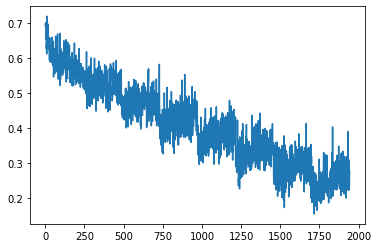

In [8]:
plt.plot(loss_c)

In [9]:
# seed 10
s = time()
model_max, loss_c, loss_r, loss_p = main_dde_nn(10)
e = time()
print(e-s)

/home/kh2383/pytorch-gpu/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'dde_torch.dde_NN_Large_Predictor' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


--- Data Preparation ---
--- Pre-training Starts ---
--- Go for Training ---
Training at Epoch 0 iteration 0, total loss is 0.710, proj loss is 0.011, recon loss is 0.005, classification loss is 0.694
Training at Epoch 0 iteration 20, total loss is 0.713, proj loss is 0.076, recon loss is 0.005, classification loss is 0.632
Training at Epoch 0 iteration 40, total loss is 0.686, proj loss is 0.047, recon loss is 0.005, classification loss is 0.634
Training at Epoch 0 iteration 60, total loss is 0.704, proj loss is 0.062, recon loss is 0.005, classification loss is 0.636
Training at Epoch 0 iteration 80, total loss is 0.668, proj loss is 0.048, recon loss is 0.005, classification loss is 0.614
Training at Epoch 0 iteration 100, total loss is 0.642, proj loss is 0.052, recon loss is 0.005, classification loss is 0.585
Training at Epoch 0 iteration 120, total loss is 0.651, proj loss is 0.049, recon loss is 0.005, classification loss is 0.597
Training at Epoch 0 iteration 140, total loss i

Training at Epoch 4 iteration 240, total loss is 0.580, proj loss is 0.153, recon loss is 0.005, classification loss is 0.422
Val at Epoch 4 , AUC: 0.846897379346
Training at Epoch 5 iteration 0, total loss is 0.471, proj loss is 0.189, recon loss is 0.005, classification loss is 0.277
Training at Epoch 5 iteration 20, total loss is 0.422, proj loss is 0.122, recon loss is 0.005, classification loss is 0.295
Training at Epoch 5 iteration 40, total loss is 0.360, proj loss is 0.101, recon loss is 0.005, classification loss is 0.254
Training at Epoch 5 iteration 60, total loss is 0.554, proj loss is 0.199, recon loss is 0.005, classification loss is 0.350
Training at Epoch 5 iteration 80, total loss is 0.323, proj loss is 0.037, recon loss is 0.005, classification loss is 0.280
Training at Epoch 5 iteration 100, total loss is 0.347, proj loss is 0.047, recon loss is 0.005, classification loss is 0.295
Training at Epoch 5 iteration 120, total loss is 0.441, proj loss is 0.089, recon loss 

In [10]:
# seed 15
s = time()
model_max, loss_c, loss_r, loss_p = main_dde_nn(15)
e = time()
print(e-s)

/home/kh2383/pytorch-gpu/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'dde_torch.dde_NN_Large_Predictor' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


--- Data Preparation ---
--- Pre-training Starts ---
--- Go for Training ---
Training at Epoch 0 iteration 0, total loss is 0.719, proj loss is 0.010, recon loss is 0.005, classification loss is 0.703
Training at Epoch 0 iteration 20, total loss is 0.734, proj loss is 0.073, recon loss is 0.005, classification loss is 0.657
Training at Epoch 0 iteration 40, total loss is 0.655, proj loss is 0.050, recon loss is 0.005, classification loss is 0.601
Training at Epoch 0 iteration 60, total loss is 0.653, proj loss is 0.043, recon loss is 0.005, classification loss is 0.605
Training at Epoch 0 iteration 80, total loss is 0.684, proj loss is 0.046, recon loss is 0.005, classification loss is 0.633
Training at Epoch 0 iteration 100, total loss is 0.623, proj loss is 0.050, recon loss is 0.005, classification loss is 0.568
Training at Epoch 0 iteration 120, total loss is 0.669, proj loss is 0.053, recon loss is 0.005, classification loss is 0.610
Training at Epoch 0 iteration 140, total loss i

Training at Epoch 4 iteration 240, total loss is 0.481, proj loss is 0.057, recon loss is 0.005, classification loss is 0.419
Val at Epoch 4 , AUC: 0.848153317709
Training at Epoch 5 iteration 0, total loss is 0.334, proj loss is 0.092, recon loss is 0.005, classification loss is 0.237
Training at Epoch 5 iteration 20, total loss is 0.330, proj loss is 0.054, recon loss is 0.005, classification loss is 0.271
Training at Epoch 5 iteration 40, total loss is 0.353, proj loss is 0.069, recon loss is 0.005, classification loss is 0.278
Training at Epoch 5 iteration 60, total loss is 0.386, proj loss is 0.043, recon loss is 0.005, classification loss is 0.338
Training at Epoch 5 iteration 80, total loss is 0.379, proj loss is 0.077, recon loss is 0.005, classification loss is 0.297
Training at Epoch 5 iteration 100, total loss is 0.405, proj loss is 0.052, recon loss is 0.005, classification loss is 0.348
Training at Epoch 5 iteration 120, total loss is 0.373, proj loss is 0.072, recon loss 

In [11]:
# seed 15
s = time()
model_max, loss_c, loss_r, loss_p = main_dde_nn(20)
e = time()
print(e-s)

--- Data Preparation ---


/home/kh2383/pytorch-gpu/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'dde_torch.dde_NN_Large_Predictor' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


--- Pre-training Starts ---
--- Go for Training ---
Training at Epoch 0 iteration 0, total loss is 0.705, proj loss is 0.010, recon loss is 0.005, classification loss is 0.690
Training at Epoch 0 iteration 20, total loss is 0.729, proj loss is 0.095, recon loss is 0.005, classification loss is 0.630
Training at Epoch 0 iteration 40, total loss is 0.670, proj loss is 0.052, recon loss is 0.005, classification loss is 0.614
Training at Epoch 0 iteration 60, total loss is 0.687, proj loss is 0.068, recon loss is 0.005, classification loss is 0.614
Training at Epoch 0 iteration 80, total loss is 0.636, proj loss is 0.058, recon loss is 0.005, classification loss is 0.572
Training at Epoch 0 iteration 100, total loss is 0.593, proj loss is 0.052, recon loss is 0.005, classification loss is 0.535
Training at Epoch 0 iteration 120, total loss is 0.679, proj loss is 0.065, recon loss is 0.005, classification loss is 0.609
Training at Epoch 0 iteration 140, total loss is 0.623, proj loss is 0.0

Training at Epoch 4 iteration 240, total loss is 0.483, proj loss is 0.047, recon loss is 0.005, classification loss is 0.431
Val at Epoch 4 , AUC: 0.847978781351
Training at Epoch 5 iteration 0, total loss is 0.362, proj loss is 0.089, recon loss is 0.005, classification loss is 0.268
Training at Epoch 5 iteration 20, total loss is 0.381, proj loss is 0.076, recon loss is 0.005, classification loss is 0.300
Training at Epoch 5 iteration 40, total loss is 0.408, proj loss is 0.060, recon loss is 0.005, classification loss is 0.342
Training at Epoch 5 iteration 60, total loss is 0.358, proj loss is 0.085, recon loss is 0.005, classification loss is 0.268
Training at Epoch 5 iteration 80, total loss is 0.358, proj loss is 0.057, recon loss is 0.005, classification loss is 0.296
Training at Epoch 5 iteration 100, total loss is 0.412, proj loss is 0.056, recon loss is 0.005, classification loss is 0.350
Training at Epoch 5 iteration 120, total loss is 0.377, proj loss is 0.072, recon loss 

In [12]:
# seed 15
s = time()
model_max, loss_c, loss_r, loss_p = main_dde_nn(25)
e = time()
print(e-s)

--- Data Preparation ---


/home/kh2383/pytorch-gpu/py3.6.3/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'dde_torch.dde_NN_Large_Predictor' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


--- Pre-training Starts ---
--- Go for Training ---
Training at Epoch 0 iteration 0, total loss is 0.713, proj loss is 0.010, recon loss is 0.005, classification loss is 0.698
Training at Epoch 0 iteration 20, total loss is 0.736, proj loss is 0.074, recon loss is 0.005, classification loss is 0.657
Training at Epoch 0 iteration 40, total loss is 0.668, proj loss is 0.058, recon loss is 0.005, classification loss is 0.604
Training at Epoch 0 iteration 60, total loss is 0.645, proj loss is 0.050, recon loss is 0.005, classification loss is 0.590
Training at Epoch 0 iteration 80, total loss is 0.666, proj loss is 0.055, recon loss is 0.005, classification loss is 0.606
Training at Epoch 0 iteration 100, total loss is 0.653, proj loss is 0.061, recon loss is 0.005, classification loss is 0.587
Training at Epoch 0 iteration 120, total loss is 0.656, proj loss is 0.077, recon loss is 0.005, classification loss is 0.574
Training at Epoch 0 iteration 140, total loss is 0.640, proj loss is 0.0

Training at Epoch 4 iteration 240, total loss is 0.389, proj loss is 0.073, recon loss is 0.005, classification loss is 0.312
Val at Epoch 4 , AUC: 0.847378653419
Training at Epoch 5 iteration 0, total loss is 0.402, proj loss is 0.103, recon loss is 0.005, classification loss is 0.294
Training at Epoch 5 iteration 20, total loss is 0.581, proj loss is 0.102, recon loss is 0.005, classification loss is 0.474
Training at Epoch 5 iteration 40, total loss is 0.468, proj loss is 0.195, recon loss is 0.005, classification loss is 0.268
Training at Epoch 5 iteration 60, total loss is 0.582, proj loss is 0.276, recon loss is 0.005, classification loss is 0.301
Training at Epoch 5 iteration 80, total loss is 0.430, proj loss is 0.042, recon loss is 0.005, classification loss is 0.383
Training at Epoch 5 iteration 100, total loss is 0.482, proj loss is 0.103, recon loss is 0.005, classification loss is 0.374
Training at Epoch 5 iteration 120, total loss is 0.387, proj loss is 0.095, recon loss 